In [1]:
%matplotlib inline
from pylab import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from lxml import etree
import requests
from IPython.display import display, HTML
import pprint

## DATA EXTRACTION

For this homework we need to extract all the information needed from **IS-Academia**. In order to to this, we have scrapped the web portal code to get all the parameters needed, performed **GET requests** to the server with the desired values of those parameters and transformed the response data into a **Pandas DataFrame**. These steps are described in a more detailed way below.

### UNDERSTANDING THE FORM

The first key thing we need to do before anything else is understand which parameters the server accepts to perform queries over the database. We need to store a **Dictionary** with the following structure:

- **Key**: Name of the parameter 
- **Value**: Dictionary Object:
    - **Key**: Name of the option chosen for the parameter
    - **Value**: Hidden ID assigned to the parameter chosen

This way we can have in a single Dictionary all the possible options we have for each parameter, as well as their unique ID, needed to perform the GET requests. We have achieved it with BeautifulSoup. The code and the Dictionary obtained (`queries_map`) can be seen below.

In [2]:
headers = {
    'x-devtools-emulate-network-conditions-client-id': "c60c3ba6-26e8-45ce-9f9f-0b5521437cf6",
    'upgrade-insecure-requests': "1",
    'user-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36",
    'accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    'referer': "http://isa.epfl.ch/imoniteur_ISAP/%21gedpublicreports.htm?ww_i_reportmodel=133685247",
    'accept-encoding': "gzip, deflate, sdch",
    'accept-language': "es-ES,es;q=0.8",
    'cookie': "LANGUE_LOGIN=fr",
    'cache-control': "no-cache"
}

data = requests.get("http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247", headers=headers)

soup = BeautifulSoup(data.content, 'html.parser')
queries = soup.find_all('select')
queries_map = {}
for s in queries:
    queries_map[s.get('name')] = {}
    map = queries_map[s.get('name')]
    options = s.find_all('option')
    for o in options:
        if not o.string:
            value = ""
        else:
            value = o.string
        map[value] = o.get('value')

The variables `queries_map` now has stored all the information we need to perform our GET requests. We'll just iterate through the Academic Periodes, Pedagogic Periodes and Academic Units, translate them to their ID and send the GET petition. The structure of `queries_map` can be found below.

In [3]:
pp = pprint.PrettyPrinter(indent=0)
pp.pprint(queries_map)

{'ww_x_HIVERETE': {'': 'null',
                 "Semestre d'automne": '2936286',
                 'Semestre de printemps': '2936295'},
'ww_x_PERIODE_ACAD': {'': 'null',
                     '2007-2008': '978181',
                     '2008-2009': '978187',
                     '2009-2010': '978195',
                     '2010-2011': '39486325',
                     '2011-2012': '123455150',
                     '2012-2013': '123456101',
                     '2013-2014': '213637754',
                     '2014-2015': '213637922',
                     '2015-2016': '213638028',
                     '2016-2017': '355925344'},
'ww_x_PERIODE_PEDAGO': {'': 'null',
                       'Bachelor semestre 1': '249108',
                       'Bachelor semestre 2': '249114',
                       'Bachelor semestre 3': '942155',
                       'Bachelor semestre 4': '942163',
                       'Bachelor semestre 5': '942120',
                       'Bachelor semestre 5b': '222676

### GETTING THE RAW DATA

Now that we have the hidden ID for each parameter, we need to know how to request the information to the server. We've used Postman to test it. The main problem encountered is that one GET request is not enough, because you need to get the `ww_x_GPS` variable for the downloadable information to be able to access it. In other words, we need to:
1. Request all the possible downloadable files for the desired parameters
2. Get the `ww_x_GPS` value for the desired one (we need to point to the proper document, we don't want to download all the data returned e.g. *Passerelle HES - IN, 2008-2009, Bachelor semestre 3*)
3. Request the information of the pointed document, the one we actually need for that semester and year (e.g. *Informatique, 2008-2009, Bachelor semestre 3*)

Our method `getData()` receives as parameters the queries as Strings. It translates them to ID and perform a GET request (equivalent to press *OK* in the web form). Then we use again *BeautifulSoup* to get the hidden *GPS* value for the desired document and we perform another GET request pointing to that document. The final result is a table returned as HTML text (raw data), that the function returns without modifying.

In [4]:
def getData(unite_acad, periode_acad, periode_pedago, semester_type):
    
    # We translate the Strings to numeric IDs
    unite_acad_id = queries_map['ww_x_UNITE_ACAD'][unite_acad]
    periode_acad_id = queries_map['ww_x_PERIODE_ACAD'][periode_acad]
    periode_pedago_id = queries_map['ww_x_PERIODE_PEDAGO'][periode_pedago]
    semester_type_id = queries_map['ww_x_HIVERETE'][semester_type]
    url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter"

    # First GET request (we submit the form)
    querystring = {"ww_b_list":"1",
                   "ww_i_reportmodel":"133685247",
                   "ww_c_langue":"",
                   "ww_i_reportModelXsl":"133685270",
                   "zz_x_UNITE_ACAD": unite_acad,
                   "ww_x_UNITE_ACAD": unite_acad_id,
                   "zz_x_PERIODE_ACAD": periode_acad,
                   "ww_x_PERIODE_ACAD":periode_acad_id,
                   "zz_x_PERIODE_PEDAGO":periode_pedago,
                   "ww_x_PERIODE_PEDAGO":periode_pedago_id,
                   "zz_x_HIVERETE":semester_type,
                   "ww_x_HIVERETE":semester_type_id,
                   "dummy":"ok"}

    headers = {
        'upgrade-insecure-requests': "1",
        'user-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36",
        'accept': "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
        'referer': "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247",
        'accept-encoding': "gzip, deflate, sdch",
        'accept-language': "es-ES,es;q=0.8",
        'cookie': "LANGUE_LOGIN=fr",
        'cache-control': "no-cache",
        'postman-token': "65d96955-59bb-daa2-5136-807135f5b89a"
        }

    # We parse the response to analyze it 
    text = BeautifulSoup(requests.request("GET", url, headers=headers, params=querystring).text, 'html.parser')
    
    # In case the results are not empty, the document we want to get is always the second one linked (Below *Tous*)
    # We can extract this value with a single *BeautifulSoup* sentence
    if (len(text.find_all('table')[2].find_all('tr')) != 0):
        gps = list(text.find_all('table'))[2].find_all('tr')[1].td.a.get('onclick').split('ww_x_GPS=')[1].split("')")[0]
        
        #Once we've got it, we perform the second GET request
        payload = {'ww_x_GPS': int(gps),
                   'ww_i_reportModel':133685247, 
                   'ww_i_reportModelXsl': 133685271,
                   'ww_x_UNITE_ACAD': unite_acad_id,
                   'ww_x_PERIODE_ACAD': periode_acad_id,
                   'ww_x_PERIODE_PEDAGO': periode_pedago_id,
                   'ww_x_HIVERETE': semester_type_id
                  }
        
        # The response contains the HTML table with all the student information, we return it without any modification
        r = requests.get("http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.XLS", params=payload)
        return r.text
    #In case the table is empty the returned data is an empty string (for future comprobations)
    else:
        return ''

### TRANSFORMING THE DATA

We've managed to code a method that gets us all the data we need for any specific parameter values, but this is not enough yet. Right now the returned data is not usable, given that it is given as an HTML table. We need to make this data accessible as a *Pandas DataFrame*, as efficiently as possible.

To achieve this goal, we've decided to use, again, *BeautifulSoup*. Thanks to this library, we can iterate through all the response text and, row by row, create a *Pandas DataFrame* without losing any piece of information. The main advantage of doing it this way is that we don't need to store the information in a different external file to read it later.

So, what does our method do? 

1. We parse the data with *BeautifulSoup*
2. We store the table column titles to know what each column represents  
3. We append our own columns:
    - One column per Pedagogic Periode: will contain Boolean values. (e.g. 'semestre 1', 'semestre 2'...)
    - One 'enter' column: will contain String values, the first Academic Year for the student (e.g. '2007-2008')
    - One 'exit' column: will contain String values, the last Academic Year for the student (e.g. '2010-2011')
4. We iterate through the *Soup* data to fill all the columns for each student.
5. We have our DataFrame! 

To make the data manipulation easier the future steps, this DataFrame will have as index the values of the *'No Sciper'* column. We have chosen this column because all the Sciper numbers are unique, so we can be sure that there won't be any overlapping.


In [5]:
# Future Pandas DataFrames that will be used to store the year and final student data (explained later)
df_final = None
df_year = None

def addData(unite_acad, periode_acad, periode_pedago, semester_type, list_semesters):

    # Same as before, we 'translate' from String to ID
    unite_acad_id = queries_map['ww_x_UNITE_ACAD'][unite_acad]
    periode_acad_id = queries_map['ww_x_PERIODE_ACAD'][periode_acad]
    periode_pedago_id = queries_map['ww_x_PERIODE_PEDAGO'][periode_pedago]
    semester_type_id = queries_map['ww_x_HIVERETE'][semester_type]

    # We get the raw data with our previous method
    text_to_soup = getData(unite_acad,periode_acad,periode_pedago,semester_type)
    
    # Required comprobation: if the returned text is an empty string, the query did not match any result
    # Must return a None (for future comprobations)
    if text_to_soup == '':
        return None
    
    # We Soup the text
    soup = BeautifulSoup(text_to_soup, 'html.parser')
    
    # We find all the rows of the table
    #      - The 1st two rows are useless
    #      - The 3rd row contains the column titles
    #      - The following rows contain student data
    #
    # If the length is smaller than 3, the data is empty. 
    # Must return a None (for future comprobations)
    rows = soup.find_all('tr')
    if len(rows) < 3:
        return None
    
    # We get the column titles and append our own (described above)
    header_cols = rows[2].find_all('th')
    col_titles, data = [], {}
    
    for c in header_cols:
        data[c.string] = []
        col_titles.append(c.string)
        
    # One new column for each Pedagogic Periode (for each semestre/project)
    [col_titles.append(semestre.split(' ')[1] + ' ' + semestre.split(' ')[2]) for semestre in list_semesters]
    
    #By now, all the new columns appended for semestres contain NaN (explained later)
    for semestre in list_semesters:
        data[semestre.split(' ')[1] + ' ' + semestre.split(' ')[2]] = [ float('nan') ] * ( len(rows) - 3)
    
    # New columns 'enter' and 'exit'. By now, the contain None
    col_titles.append('enter')
    data['enter'] = None
    col_titles.append('exit')
    data['exit'] = None
    
    global df_final, df_year

    # We initialize an empty DataFrame with the column titles and 'No Sciper' as index
    df = pd.DataFrame(columns=col_titles)
    df.set_index(['No Sciper'], inplace=True, drop=False)
    
    # If it's the first iteration, we initialize df_final and df_year
    if df_final is None:
        df_final = df.copy()
    if df_year is None:
        df_year = df.copy() 
    
    # We iterate through all the students (every row) and we create a Dictionary with all the information
    # Reminding: Starting in 3 because first 2 rows are useless
    for h in range(3, len(rows)):
        values = rows[h].find_all('td')
        for v in range(len(values)-2):
            data[header_cols[v].string].append(values[v].string)
        data[periode_pedago.split(' ')[1] + ' ' + periode_pedago.split(' ')[2]][h-3] =  True
    
    # We create a new DataFrame from the Dictionary created
    # The new DataFrame has 'No Sciper' as index
    df = pd.DataFrame.from_dict(data)
    df.set_index(['No Sciper'], inplace=True, drop=False)
    
    # We have the HTML table given by the web form transformed into a Pandas DataFrame, job is done
    return df



### UPDATING THE DATA

By now, we have a method to get the data from the server and another method to parse that information into a customized Pandas DataFrame. That means that we have all the necessary to start working with the data- However, there are a couple of new methods we have to code, needed to update the data.

To get all the information, we are going to iterate through all the possible *Academic Periodes* (e.g. '2007-2008'). For each *Academic Periode*, we are going to iterate through all the possible *Pedagogic Periodes* (e.g. 'Bachelor Semestre 3'). That means we're going to have two different stored DataFrames:

- `df_year`: updated with every new DataFrame obtained for each semestre. Initialized empty in the first iteration for an *Academic Period*. Updated with `combineDataYear()` method below.
- `df_final`: updated with `df_year` in the last iteration for an *Academic Period*. Updated with `combineDataTotal` mehthod below.

At the end of all the iterations, `df_final` will have stored the most updated information about **ALL** the students. 

In [6]:
# Used to update df_year for each semestre in an Academic Period
# Receives:
#     - new_data: DataFrame obtained for a new semestre
#     - old_data: DataFrame df_year (with the updated information of all the previous semestres for that Academic Period)
#     - semestre: String of the Pedagogic Period
#     - year: String of the Academic Period
#
# Returns: the DataFrame df_year updated with the new semestre
def combineDataYear(new_data, old_data, semestre, year):
    #print(semestre, year)
    semestre_name = semestre.split(' ')[1] + ' ' + semestre.split(' ')[2]
    
    # Iterate through the students of the semestre
    for user in new_data['No Sciper'].tolist():
        # If the students was already in the old DataFrame, we have to update two values:
        #    - 'semestre_name' (defined above) column: he's registered for this semestre, so we change NaN -> True
        #    - 'exit' column: he's registered for this academic year, so he hasn't left the EPFL yet (set it to 'year' variable)
        if (user in old_data['No Sciper'].tolist()):
            #print(old_data[semestre[9:]].loc[old_data['No Sciper'] == user], "*******")
            old_data[semestre_name].loc[old_data['No Sciper'] == user] = True
            old_data['exit'].loc[old_data['No Sciper'] == user] = year
        
        # If he wasn't in the old DataFrame, we have to add him with the following values:
        #    - 'enter' column: first time he's registered, so he just got in the EPFL (set it to 'year' variable)
        #    - 'exit' column: he's registered for this academic year, so he hasn't left the EPFL yet (set it to 'year' variable)
        # We concatenate the new student to the DataFrame
        else:
            new_data['enter'].loc[new_data['No Sciper'] == user] = year
            new_data['exit'].loc[new_data['No Sciper'] == user] = year
            old_data = pd.concat([old_data, new_data.loc[new_data['No Sciper'] == user]], ignore_index=True)
            #print(new_data['semestre 1'].loc[new_data['No Sciper'] == user])
    old_data.set_index(['No Sciper'], inplace=True, drop=False)

    # All modifications for this semestre are done, so we return the new df_year DataFrame
    return old_data

# Used to update df_final for each Academic Period df_year information
# Receives:
#     - new_data: DataFrame df_year obtained for an Academic Period
#     - old_data: DataFrame df_final (with the updated information of all the previous Academic Periods)
#
# Returns: the DataFrame df_final updated with the new year
def combineDataTotal(new_data, old_data):
    # We combine both DataFrames. This way:
    #     - Students in both DataFrames combine their values. 
    #       In the 'semestre x' columns, it acts like an OR with NaN and True of both DataFrames
    old_data = old_data.combine_first(new_data)
    for user in new_data['No Sciper'].tolist():
        if user not in old_data['No Sciper'].tolist():
            old_data = pd.concat([old_data, new_data.loc[new_data['No Sciper'] == user]])
            
        #We update the 'exit' column, same reasoning as the other method
        else:
            old_data['exit'].loc[old_data['No Sciper'] == user] = new_data['exit'].loc[new_data['No Sciper'] == user]
    old_data.set_index(['No Sciper'], inplace=True, drop=False)
    
    # All the modifications for this year are done, so we return the new df_final DataFrame
    return old_data

## EXERCISE 1
==========


Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both Bachelor semestre 1 and Bachelor semestre 6. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?

In [7]:

#We just need the Informatique students
unite_acad = "Informatique"

#We want all the Academic Periods (From 2007 to 2017)
# We remove '' because we don't want to download all the data at once, we are going to iterate
periode_acad = list(queries_map['ww_x_PERIODE_ACAD'].keys())
periode_acad.remove('')

# We want all the Bachelor Semestres, removing 5b and 6b (always empty)
periode_pedago = []
for p in list(queries_map['ww_x_PERIODE_PEDAGO'].keys()):
    if 'Bachelor' in p and "b" not in p:
        periode_pedago.append(p)

# All the iterations will be in ordered chronologically
periode_pedago = sorted(periode_pedago)
periode_acad = sorted(periode_acad)

df_final = None
df_year = None

# We Iterate through all the Academic Periods
for year in range(len(periode_acad)):
    df_year = None
    # For each Academic Period, we iterate through all the Pedagogic Periods
    for s in range(len(periode_pedago)):
        # We get the data for that Academic and Pedagogic Period
        a = addData("Informatique", periode_acad[year], periode_pedago[s], "", periode_pedago)
        
        # Empty comprobation (there wasn't any data for that query)
        if a is None:
            continue
        
        # We combine our new data with the data already stored from previous iterations in that Academic Period
        df_year = combineDataYear(a, df_year, periode_pedago[s], periode_acad[year])
    # We combine our new data with the data already stored from previous Academic Periods
    df_final = combineDataTotal(df_year, df_final)
    
display(df_final)

/Users/juanluismoralperez/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Civilité,Ecole Echange,Filičre opt.,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,enter,exit,semestre 1,semestre 2,semestre 3,semestre 4,semestre 5,semestre 6
No Sciper,,,,,,,,,,,,,,,,,,,
147008,Monsieur,Carnegie Mellon University Pittsburgh,NaN,NaN,147008,Good Xavier,NaN,NaN,NaN,Présent,Bilatéral,2008-2009,2010-2011,True,True,True,True,True,True
153762,Monsieur,NaN,NaN,NaN,153762,Conus Johann,NaN,NaN,NaN,Présent,NaN,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,True
154157,Madame,NaN,NaN,NaN,154157,Andriambololona Riana Miarantsoa,NaN,NaN,NaN,Présent,NaN,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,NaN
159516,Monsieur,NaN,NaN,NaN,159516,Raja Yanick,NaN,NaN,NaN,Présent,NaN,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,True
159998,Madame,NaN,NaN,NaN,159998,Jesse Julia,NaN,NaN,NaN,Présent,NaN,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,True
160213,Monsieur,NaN,NaN,NaN,160213,Bécholey Alexandre,NaN,NaN,NaN,Présent,NaN,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,NaN
161091,Madame,NaN,NaN,NaN,161091,Grivet Ekaterina,NaN,NaN,NaN,Congé,NaN,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,True
161127,Monsieur,NaN,NaN,NaN,161127,Sahy François,NaN,NaN,NaN,Congé,NaN,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,True
161212,Monsieur,NaN,NaN,NaN,161212,Tamesna Rachid,NaN,NaN,NaN,Présent,NaN,2009-2010,2009-2010,True,True,NaN,NaN,NaN,NaN


We can see the final data in table. If we watch carefully, we can find some columns ( `Ecole Echange`, `Filičre opt.`, `Mineur`, `Orientation Bachelor`, `Orientation Master`, `Spécialisation', 'Type Echange` ) that haven't been used. So, we <code>drop</code> this columns. The result table is below.
 

In [8]:
df_final.drop(['Ecole Echange', 'Filičre opt.', 'Mineur', 'Orientation Bachelor','Orientation Master', 'Spécialisation', 'Type Echange' ],1)



,Civilité,No Sciper,Nom Prénom,Statut,enter,exit,semestre 1,semestre 2,semestre 3,semestre 4,semestre 5,semestre 6
No Sciper,,,,,,,,,,,,
147008,Monsieur,147008,Good Xavier,Présent,2008-2009,2010-2011,True,True,True,True,True,True
153762,Monsieur,153762,Conus Johann,Présent,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,True
154157,Madame,154157,Andriambololona Riana Miarantsoa,Présent,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,NaN
159516,Monsieur,159516,Raja Yanick,Présent,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,True
159998,Madame,159998,Jesse Julia,Présent,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,True
160213,Monsieur,160213,Bécholey Alexandre,Présent,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,NaN
161091,Madame,161091,Grivet Ekaterina,Congé,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,True
161127,Monsieur,161127,Sahy François,Congé,2007-2008,2007-2008,NaN,NaN,NaN,NaN,True,True
161212,Monsieur,161212,Tamesna Rachid,Présent,2009-2010,2009-2010,True,True,NaN,NaN,NaN,NaN


After deleting useless columns, we select the people who have finished the Balchelor. So, we have to remove people who haven't been registered to both Semestre 1 and 6 (this includes people who started the Bachelor before the DB was created). Finally, we plot the results in a pie chart.

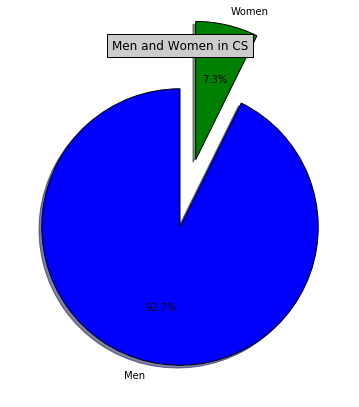

In [9]:
# We only take the entries with 'semestre 1' and 'semestre 6' as True
df_final_sm1 = df_final[df_final['semestre 1'] == True]
df_final = df_final_sm1[df_final_sm1['semestre 6'] == True]

# Count of women, men and total
num_total = len(df_final)
num_women = len(df_final[df_final['Civilité'] == 'Madame'])

# Make a square figure and axes
figure(1, figsize=(6,6))
ax = axes([0.1, 0.1, 0.8, 0.8])

labels = 'Men', 'Women'
fracs = [num_total-num_women, num_women]
explode=(0, 0.5)

pie(fracs, explode=explode, labels=labels,
                autopct='%1.1f%%', shadow=True, startangle=90)

title('Men and Women in CS', bbox={'facecolor':'0.8', 'pad':5})

show()

At the pie graph, we can see that male's number dominate over female's number. Only, 7,3%(29) are women in contrast with 92,7% (368) of men. 

In [10]:
def calculateMeanDate(init_dates):
    durations = []
    for i in init_dates:
        init = int(i[0].split('-')[0])
        final = int(i[1].split('-')[1])
        months = (final - init)*12 - 3
        durations.append(months)
    return sum(durations)/len(durations)
mean_T = calculateMeanDate(df_final[['enter', 'exit']].as_matrix())
mean_w = calculateMeanDate(df_final[df_final['Civilité'] == 'Madame'][['enter', 'exit']].as_matrix())
mean_m = calculateMeanDate(df_final[df_final['Civilité'] == 'Monsieur'][['enter', 'exit']].as_matrix())

Now, we are going to observe the 'mean time to finish Balchelor between sex' graph. 

Mean total =  40.8287153652 
Mean female =  38.7931034483 
Mean male =  40.9891304348 
Number of month of Balchelor =  36


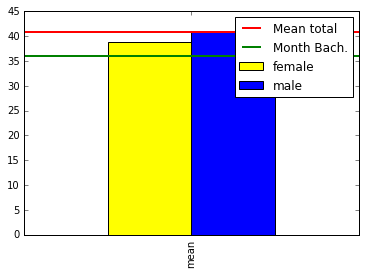

In [26]:
pd.DataFrame({'male': [mean_m], 'female' : [mean_w]}, index = ['mean']).plot.bar(color = ['#FFFF00', '#0000FF' ]);
plt.axhline(y=mean_T, xmin=0, xmax=1, hold=None, color='r', linewidth = 2.0, label='Mean total')
plt.axhline(y= 6 * 6, xmin=0, xmax=1, hold=None, color='g', linewidth = 2.0, label= 'Month Bach.')
plt.legend()
#Moth Balchelor 6 * 6 = 6 month (2 semester/year * 3 years)
print('Mean total = ', mean_T, '\nMean female = ', mean_w, '\nMean male = ', mean_m, '\nNumber of month of Balchelor = ', 6*6)

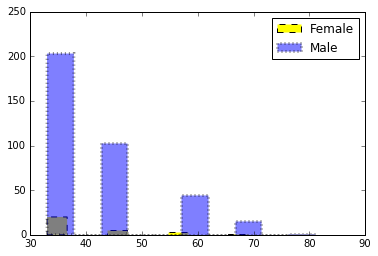

In [27]:
def calculateDate(init_dates):
    durations = []
    for i in init_dates:
        init = int(i[0].split('-')[0])
        final = int(i[1].split('-')[1])
        months = (final - init)*12 - 3
        durations.append(months)
    return durations

data_w = calculateDate(df_final[df_final['Civilité'] == 'Madame'][['enter', 'exit']].as_matrix())
data_m = calculateDate(df_final[df_final['Civilité'] == 'Monsieur'][['enter', 'exit']].as_matrix())

fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(data_w, ls='dashed', color= '#FFFF00', label=['Female'])
ax.hist(data_m, ls='dotted', alpha = 0.5, lw=3, color= '#0000FF', label=['Male'])
ax.legend()
plt.show()

In this graph whe can see distribution to do a [Chi-square](https://en.wikipedia.org/wiki/Chi-squared_test) test.
Where:
* H0: Pass the Bachelor in the computed months is independent to sex
* H1: Pass the Bachelor in the computed months isn't independent to sex

Formula Chi-square: 
${\chi}^2=\frac{1}{d}\sum_{k=1}^{n} \frac{(O_k - E_k)^2}{E_k}$



In [28]:
def tableContigence(women, men, monthBa):
    w_extraction = [0,0,0]
    for i in women:
        if i == monthBa:
            w_extraction[0] += 1
        else:
            w_extraction[1] += 1
        w_extraction[2] += 1
    m_extraction = [0,0,0]       
    for i in men:
        if i == monthBa:
            m_extraction[0] += 1
        else:
            m_extraction[1] += 1
        m_extraction[2] += 1
    t_extraction = [w_extraction[0] + m_extraction[0], w_extraction[1] + m_extraction[1], w_extraction[2] + m_extraction[2]]
    df = pd.DataFrame({'Male' : m_extraction, 'Female' : w_extraction, 'Total': t_extraction},
                      index=[['In Calculated Month (' + str(3 * 12 -3) + ')']*3, ['yes', 'no', 'total']*2])
    return df
table_conti = tableContigence(data_w, data_m, 3 * 12 -3)
display(table_conti)

total =  table_conti['Total'].loc['In Calculated Month (33)']['total']
p_male = table_conti['Male'].loc['In Calculated Month (33)']['total'] / total
p_female = table_conti['Female'].loc['In Calculated Month (33)']['total'] /  total
p_succ = table_conti['Total'].loc['In Calculated Month (33)']['yes']/  total  
p_nosucc = table_conti['Total'].loc['In Calculated Month (33)']['no'] / total

p_male_succ = table_conti['Male'].loc['In Calculated Month (33)']['yes']/  total
p_male_nosucc = table_conti['Male'].loc['In Calculated Month (33)']['no'] /  total
p_female_succ = table_conti['Female'].loc['In Calculated Month (33)']['yes']/  total
p_female_nosucc = table_conti['Female'].loc['In Calculated Month (33)']['no']/  total

e_male_succ = table_conti['Total'].loc['In Calculated Month (33)']['yes'] * table_conti['Male'].loc['In Calculated Month (33)']['total']/total
e_male_nosucc =  table_conti['Total'].loc['In Calculated Month (33)']['no'] * table_conti['Male'].loc['In Calculated Month (33)']['total']/total
e_female_succ = table_conti['Total'].loc['In Calculated Month (33)']['yes'] * table_conti['Female'].loc['In Calculated Month (33)']['total']/total
e_female_nosucc  =  table_conti['Total'].loc['In Calculated Month (33)']['no'] * table_conti['Female'].loc['In Calculated Month (33)']['total']/total


chi_sq = ((( table_conti['Male'].loc['In Calculated Month (33)']['yes'] - e_male_succ)**2 / e_male_succ) +
         ((table_conti['Male'].loc['In Calculated Month (33)']['no'] - e_male_nosucc)**2 /e_male_nosucc )+
         (( table_conti['Female'].loc['In Calculated Month (33)']['yes'] - e_female_succ)**2 / e_female_succ)+
         (( table_conti['Female'].loc['In Calculated Month (33)']['no'] - e_female_nosucc)**2 / e_female_nosucc))
print('\nReletives freqüencies:',
      '\n\tP(be male) = ', p_male * 100, '%', 
      '\n\tP(be female) = ', p_female * 100, '%',
      '\n\tP(succeful) = ', p_succ * 100, '%',
      '\n\tP(!succeful) = ', p_nosucc * 100, '%',
      '\n\nJoint relative frequencies',
      '\n\tP(be male & suc) = ', p_male_succ * 100, '%', 
      '\n\tP(be male & !nosucc female) = ', p_male_nosucc * 100, '%',
      '\n\tP(be female & succ) = ', p_female_succ * 100, '%',
      '\n\tP(be female & !nosucc) = ', p_nosucc * 100, '%',
      '\n\nTheoretical relative frequencies expected in case of independence:',
      '\n\tE(be male & suc) = ', p_male * p_succ  * 100, '%', 
      '\n\tE(be male & !nosucc female) = ', p_male * p_nosucc  * 100, '%',
      '\n\tE(be female & succ) = ', p_female * p_succ  * 100, '%',
      '\n\tE(be female & !nosucc) = ', p_female * p_nosucc  * 100, '%',
      '\n\nTheoretical absolute frequencies expected in the event of independence:',
      '\n\tE(be male & suc) = ', e_male_succ, 
      '\n\tE(be male & !nosucc female) = ', e_male_nosucc,
      '\n\tE(be female & succ) = ',e_female_succ,
      '\n\tE(be female & !nosucc) = ', e_female_nosucc,
      '\n\n Chi-square = ', chi_sq
     
     )

Female  Male  Total
In Calculated Month (33) yes        20   203    223
                         no          9   165    174
                         total      29   368    397


Reletives freqüencies: 
	P(be male) =  92.6952141058 % 
	P(be female) =  7.30478589421 % 
	P(succeful) =  56.1712846348 % 
	P(!succeful) =  43.8287153652 % 

Joint relative frequencies 
	P(be male & suc) =  51.1335012594 % 
	P(be male & !nosucc female) =  41.5617128463 % 
	P(be female & succ) =  5.03778337531 % 
	P(be female & !nosucc) =  43.8287153652 % 

Theoretical relative frequencies expected in case of independence: 
	E(be male & suc) =  52.0680925582 % 
	E(be male & !nosucc female) =  40.6271215476 % 
	E(be female & succ) =  4.10319207659 % 
	E(be female & !nosucc) =  3.20159381761 % 

Theoretical absolute frequencies expected in the event of independence: 
	E(be male & suc) =  206.710327456 
	E(be male & !nosucc female) =  161.289672544 
	E(be female & succ) =  16.2896725441 
	E(be female & !nosucc) =  12.7103274559 

 Chi-square =  2.08015679853


### Conlusion:
1. We can see that female finish the Bachelor before than males. 
2. Neither male or female can finish the Bachelor in the 33 months. More specifically, they take about 6 months more as average. 
3. We accept H0.



# EXERCISE 2
Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking the distance in months between `Master semestre 1` and `Master semestre 2`. If the `Mineur` field is *not* empty, the student should also appear registered in `Master semestre 3`. Last but not the least, don't forget to check if the student has an entry also in the `Projet Master` tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a `Spécialisation` and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?

In [7]:
#We just need the Informatique students
unite_acad = "Informatique"

# We want all the Academic Periods (From 2007 to 2017)
# We remove '' because we don't want to download all the data at once, we are going to iterate
periode_acad = list(queries_map['ww_x_PERIODE_ACAD'].keys())
periode_acad.remove('')

# We want all the Master Semestres, including projects
periode_pedago = []
for p in list(queries_map['ww_x_PERIODE_PEDAGO'].keys()):
    if 'Master' in p:
        periode_pedago.append(p)

# All the iterations will be ordered chronologically
periode_pedago = sorted(periode_pedago)
periode_acad = sorted(periode_acad)

df_final = None
df_year = None

# We Iterate through all the Academic Periods
for year in range(len(periode_acad)):
    df_year = None
    # For each Academic Period, we iterate through all the Pedagogic Periods
    for s in range(len(periode_pedago)):
        # We get the data for that Academic and Pedagogic Period
        a = addData("Informatique", periode_acad[year], periode_pedago[s], "", periode_pedago)
        
        # Empty comprobation (there wasn't any data for that query)
        if a is None:
            continue
        # We combine our new data with the data already stored from previous iterations in that Academic Period
        df_year = combineDataYear(a, df_year, periode_pedago[s], periode_acad[year])
    
    # We combine our new data with the data already stored from previous Academic Periods
    df_final= combineDataTotal(df_year, df_final)

df_final_master = df_final.copy()
display(df_final_master)



/Users/nachoaguadoc/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Civilité,Ecole Echange,Filičre opt.,Master automne,Master printemps,Mineur,No Sciper,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Statut,Type Echange,enter,exit,semestre 1,semestre 2,semestre 3,semestre 4
No Sciper,,,,,,,,,,,,,,,,,,,
128911,Monsieur,NaN,NaN,NaN,NaN,NaN,128911,Gulati Asheesh,NaN,NaN,Internet computing,Présent,NaN,2007-2008,2007-2008,NaN,True,True,NaN
129093,Monsieur,NaN,NaN,NaN,NaN,NaN,129093,Zhou Maoan,NaN,NaN,NaN,Présent,NaN,2007-2008,2007-2008,NaN,True,True,NaN
129326,Monsieur,NaN,NaN,NaN,NaN,NaN,129326,Ni Zhong Zhong,NaN,NaN,NaN,Présent,NaN,2007-2008,2007-2008,NaN,True,True,NaN
138088,Monsieur,NaN,NaN,NaN,NaN,NaN,138088,Droz-dit-Busset Arnault,NaN,NaN,NaN,Présent,NaN,2007-2008,2007-2008,True,NaN,NaN,NaN
145546,Monsieur,NaN,NaN,NaN,NaN,NaN,145546,Clivaz Jean-Philippe,NaN,NaN,NaN,Présent,NaN,2007-2008,2007-2008,NaN,NaN,True,NaN
145957,Monsieur,NaN,NaN,NaN,True,NaN,145957,Hügli Michael,NaN,NaN,NaN,Présent,NaN,2007-2008,2007-2008,NaN,NaN,True,NaN
146330,Monsieur,NaN,NaN,NaN,NaN,NaN,146330,Cardinaux Damien,NaN,NaN,NaN,Présent,NaN,2007-2008,2008-2009,True,True,True,NaN
146441,Madame,NaN,NaN,NaN,NaN,NaN,146441,Henriot Laetitia,NaN,NaN,NaN,Présent,NaN,2007-2008,2007-2008,NaN,NaN,True,NaN
146742,Monsieur,NaN,NaN,True,True,NaN,146742,Marx Clément,NaN,NaN,"Signals, Images and Interfaces",Présent,NaN,2008-2009,2012-2013,True,True,True,NaN


After loading data, we can see the final table. If we watch carefully, we can find some columns ( `Ecole Echange`, `Filičre opt.`, `Orientation Bachelor`,`Orientation Master`, `Statut`, `Type Echange`, `semestre 4` ) that we haven't used. So, we <code>drop</code> these columns (The same operation as in Exercise 1). The resulted table is below.
 

In [8]:
df_final_master = df_final_master.drop(['Ecole Echange', 'Filičre opt.', 'Orientation Bachelor','Orientation Master', 'Statut', 'Type Echange', 'semestre 4' ],1)

Once we have all the Master students data, it's time to do extract some characteristic information from it. We're going to calculate the average time every student has spent studying a Master at the EPFL by Spécialisation, as well as the total average for all the Master students. The method `calculateDate()` does that.

In [33]:
def calculateDate(init_dates, list_atributes):
    duration = []
    suma = 0
    for i in init_dates.index:
        suma = sum(init_dates.loc[[i]][list_atributes[:3]].dropna(1).values)
        if not pd.isnull(init_dates.loc[[i]][list_atributes[3]]).bool():
            suma += 1
        if not pd.isnull(init_dates.loc[[i]][list_atributes[4]]).bool() and pd.isnull(init_dates.loc[[i]][list_atributes[3]]).bool():
            suma +=1
        duration.append(suma*6)
        suma = sum(duration)/len(duration)
        if math.isnan(suma):
            return 0
    return suma

As can be seen in the graph below, the *total mean* is 16.86 months at the EPFL. The highest one is *Information Security* with 19.71 months, while the lowest one is *Biocomputing* with only 11.5 months. This is impactful because it would mean that almost no one has been able to finish the *Biocomputing* Spécialisation. One possible reason is that it's a Spécialisation created only a year ago, so their first students are still in the third semester in the best of the cases.

Internet computing mean is 17.0377358491 months
Signals, Images and Interfaces mean is 15.8918918919 months
Biocomputing mean is 11.5 months
Foundations of Software mean is 17.2727272727 months
Computer Engineering - SP mean is 17.7142857143 months
Service science mean is 19.5 months
Software Systems mean is 17.3333333333 months
Information Security - SP mean is 19.7142857143 months
Data Analytics mean is 13.5 months
Internet Information Systems mean is 18.0 months
Computer Science Theory mean is 18.0 months
The total mean is: 16.8603872523 months


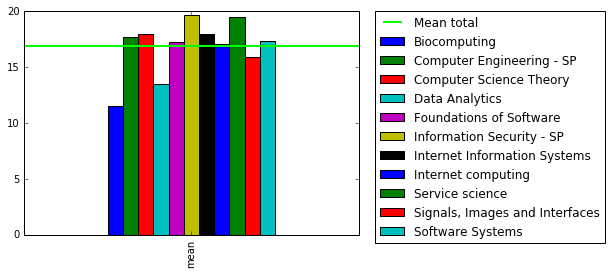

In [34]:
list_spec = df_final_master['Spécialisation'].unique()
cleanedList = np.array([spec for spec in list_spec if str(spec) != 'nan'])
list_spec = cleanedList[[cleanedList != np.array(None)]]
mean_data = []
data = {}
for spec in list_spec:
    data[spec] = calculateDate(df_final_master[df_final_master['Spécialisation'] == spec][['semestre 1','semestre 2', 'semestre 3', 'Master automne', 'Master printemps']], ['semestre 1','semestre 2', 'semestre 3', 'Master automne', 'Master printemps'])
    mean_data.append(data[spec])
    print(spec , 'mean is', data[spec], 'months')
data_spec = pd.DataFrame(data, index = ['mean']).plot.bar();
mean_total = sum(mean_data)/len(mean_data)
print('The total mean is:', mean_total, 'months')
plt.axhline(y=mean_total, xmin=0, xmax=1, hold=None, color='#00FF00', linewidth = 2.0, label = 'Mean total')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# BONUS

Perform the gender-based study also on the Master students, as explained in 1. Use scatterplots to visually identify changes over time. Plot males and females with different colors -- can you spot different trends that match the results of your statistical tests?

In the table and bar chart below can be seen the distribution of genders between all the different *Spécialisations* of the EPFL. It's specially relevant (although not surprising or shocking) the cases of:
- *Internet Computing*, where only 23 out of 256 students are women (about 9%). 
- *Computer Science Theory* has an important lack of women, where all their 4 students are men.
- *Software Systems*, with a 6% of female students

On the opposite hand, in *Biocomputing*, the percentage grows to 52,2%, considerably bigger than the rest of them.

In [35]:
df_final_grouped = df_final_master.drop(['Mineur', 'No Sciper', 'Nom Prénom', 'enter','exit'],1)
df_final_grouped=df_final_grouped.groupby(['Spécialisation', 'Civilité']).count().sum(axis = 1)
display(pd.DataFrame(df_final_grouped))

0
Spécialisation                 Civilité     
Biocomputing                   Madame     12
                               Monsieur   23
Computer Engineering - SP      Madame     13
                               Monsieur   70
Computer Science Theory        Monsieur    4
Data Analytics                 Madame      4
                               Monsieur   22
Foundations of Software        Madame     23
                               Monsieur  233
Information Security - SP      Monsieur   30
Internet Information Systems   Madame      4
Internet computing             Madame     39
                               Monsieur  369
Service science                Madame      4
                               Monsieur   13
Signals, Images and Interfaces Madame     14
                               Monsieur  122
Software Systems               Madame      4
                               Monsieur   66

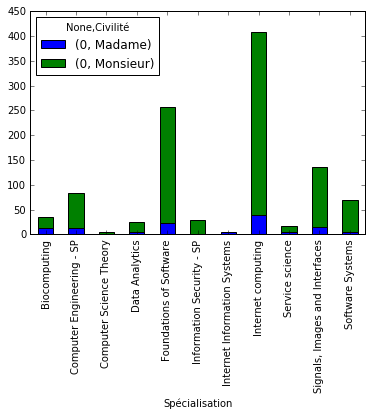

In [36]:
pd.DataFrame(df_final_grouped).unstack().plot.bar(stacked=True,by='Spécialisation')

Finally, we perform the gender analysis for the Master students to get the average time spent at EPFL by both *Civilité* and *Spécialisation*. Once again, biocomputing is the lowest one for both men and women

Internet computing for Madame , the mean is 15.2727272727 months
Internet computing for Monsieur , the mean is 17.2421052632 months
Signals, Images and Interfaces for Madame , the mean is 15.0 months
Signals, Images and Interfaces for Monsieur , the mean is 16.0 months
Biocomputing for Madame , the mean is 18.0 months
Biocomputing for Monsieur , the mean is 9.33333333333 months
Foundations of Software for Madame , the mean is 17.0 months
Foundations of Software for Monsieur , the mean is 17.3 months
Computer Engineering - SP for Madame , the mean is 20.0 months
Computer Engineering - SP for Monsieur , the mean is 17.3333333333 months
Service science for Madame , the mean is 18.0 months
Service science for Monsieur , the mean is 20.0 months
Software Systems for Madame , the mean is 18.0 months
Software Systems for Monsieur , the mean is 17.2941176471 months
Information Security - SP for Madame , the mean is 0 months
Information Security - SP for Monsieur , the mean is 19.7142857143 mont

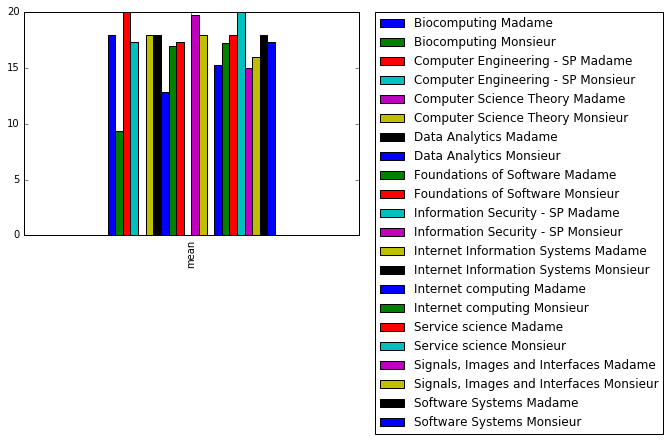

In [41]:
mean_data = []
data = {}

for spec in list_spec:
    for sex in ['Madame', 'Monsieur']:
        data[spec + ' ' + sex] = calculateDate(df_final_master[(df_final_master.Spécialisation == spec) & (df_final_master.Civilité == sex)][['semestre 1','semestre 2', 'semestre 3', 'Master automne', 'Master printemps']], ['semestre 1','semestre 2', 'semestre 3', 'Master automne', 'Master printemps'])
        mean_data.append(data[spec + ' ' + sex])
        print(spec, 'for', sex , ', the mean is', data[spec + ' ' + sex], 'months')

data_spec = pd.DataFrame(data, index = ['mean']).plot.bar();

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()